# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
!pip install helper
import helper
import json
from workspace_utils import active_session
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

  Running setup.py bdist_wheel for helper ... done
  Stored in directory: /root/.cache/pip/wheels/18/de/25/a8d15addb213a842c551d25dd9994aebc1e4dd97f7c681e0ea
Successfully built helper


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
tune_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define the transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.25),
                                      transforms.RandomVerticalFlip(p=0.25),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
tune_data = datasets.ImageFolder(tune_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
batch_size = 64
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
tuneloader = torch.utils.data.DataLoader(tune_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
'''
# Display an image - Doesnt work why?
dataiter = iter(trainloader)
images, labels = dataiter.next() # gives me all the image and corr labels
print(f'Image type: {type(images)}')
print(f'Image shape: {images.shape}')
print(f'Label shape: {labels.shape}')

i1 = images[1]
plt.axis('off')
plt.imshow(i1.numpy().squeeze().transpose(1,2,0));
'''


"\n# Display an image - Doesnt work why?\ndataiter = iter(trainloader)\nimages, labels = dataiter.next() # gives me all the image and corr labels\nprint(f'Image type: {type(images)}')\nprint(f'Image shape: {images.shape}')\nprint(f'Label shape: {labels.shape}')\n\ni1 = images[1]\nplt.axis('off')\nplt.imshow(i1.numpy().squeeze().transpose(1,2,0));\n"

In [5]:
'''
# Display images - Doesnt work why?
plt.figure()
nr_images = 9

for idx in range(1, nr_images + 1):
    #print(idx)
    plt.subplot(nr_images/3, nr_images/3, idx)
    #i1 = images[i,:,:,:]
    #i1.shape
    plt.tight_layout()
    plt.axis('off');
    plt.imshow(images[idx].numpy().squeeze().transpose(1,2,0));

plt.show();
'''
'''
So as you can see in the output of the cell, the dimensions of the images tensor is as follows [30, 3, 224, 224] where 30 is the batch size.
Now, if you extract one image out of it, the shape of the single image tensor would be as follows [3, 224, 224] format -> [depth, height, width]
In deep learning libraries, the depth dimension (3) comes before height and width. But for image plotting libraries, the expected format is -> [height, width, depth] i.e. the depth dimension comes last.
So you need to swap the tensor axis as follows plt.imshow(images[0].numpy().squeeze().transpose(1,2,0))
'''

'\nSo as you can see in the output of the cell, the dimensions of the images tensor is as follows [30, 3, 224, 224] where 30 is the batch size.\nNow, if you extract one image out of it, the shape of the single image tensor would be as follows [3, 224, 224] format -> [depth, height, width]\nIn deep learning libraries, the depth dimension (3) comes before height and width. But for image plotting libraries, the expected format is -> [height, width, depth] i.e. the depth dimension comes last.\nSo you need to swap the tensor axis as follows plt.imshow(images[0].numpy().squeeze().transpose(1,2,0))\n'

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
# label for classification
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

## Build & Train the Network

In [7]:
# -- BUILD THE MODEL
# Run on GPU if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# Load the pre-built and pre-trained model
model = models.vgg16(pretrained=True)

# Freeze the parameters for the pre-trained model, so we dont backprop through them
for param in model.parameters():
    param.requires_grad = False
    
# Define model
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 512)),
    ('relu1', nn.ReLU()),
    ('do1', nn.Dropout(0.2)),
    ('fc2', nn.Linear(512, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

# Define the model to be trained
model.classifier = classifier # the model pre-trained model VGG doesnt have .fc but .classifier

# Define loss function
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
 
# Send model to device
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 69237322.83it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
# -- TRAIN THE MODEL
import timeit

start = timeit.timeit()

# For long running code keep the session active
with active_session():
    
    # Def of variables
    epochs = 3 # nr of trainings
    steps = 0
    running_loss = 0
    print_every = 5
    run_accuracy = 0
    train_losses, tune_losses = [], []
    train_accuracy, tune_accuracy = [], []
    
    # Training
    for epoch in range(epochs): # nr of traning times
        
        for inputs, labels in trainloader: # loop through the data
            
            steps += 1 # train steps
            #print(inputs.size())
            # Move input and label tensors to the default device (GPU if available)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the gradients - very important
            optimizer.zero_grad()
            
            # Forward pass -> log probabilities
            logps = model.forward(inputs)
            
            # Define loss
            loss = criterion(logps, labels)
            
            # Backward pass
            loss.backward()
            
            # Take a step towards lower loss
            optimizer.step()
            
            # Keep track on the total loss
            running_loss += loss.item()
            
            # calculate the accuracy
            ps = torch.exp(logps) # get the actual probability
            top_p, top_class = ps.topk(1, dim=1) # top probabilities and classes

            equals = top_class == labels.view(*top_class.shape) # check how many images which have the correct classification. 
            # That *top_class.shape is passing all of the items in the top_class.shape into the view function call as separate arguments, without us even needing to know how many arguments are in the list. For example if the top_class has a shape say (32, 1), so *top_class.shape will pass 32, 1 to view function. Now this is as good as passing (top_class.shape[0],top_class.shape[1]). labels.view(top_class.shape[0],top_class.shape[1]) is equal to labels.view(*top_class.shape). The labels.view(*top_class.shape) is very useful because we dont have to know the exact shape for us to reshape them, we just use * and it will pack everything into a list and pass on to the view function for reshaping

            run_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # after getting the top_class of the top_probability from torch.exp(output), we equal the top_class with the images labels (targets) to check if they match or not. The result from this equality is binary values [0,1]. Does this mean that 1 refers to class-label matching and 0 refers to class-label mismatching? Yes
            
            # Tune/evaluate the model every print_every 5 times
            if steps % print_every == 0:
                tune_loss = 0
                accuracy = 0
                model.eval() # set model in evaluation mode
                
                with torch.no_grad(): # reduces memory usage - we dont need to calculate the gradients in evaluation mode
                    
                    for images, labels in tuneloader:
                        
                        # Move images and labels tensors to the default device (GPU if available)
                        images = images.to(device)
                        labels = labels.to(device)
                        
                        # Calculate the loss
                        log_ps = model(images) # log of probability
                        loss = criterion(log_ps, labels)
                        tune_loss += loss.item()

                        # calculate the accuracy
                        ps = torch.exp(log_ps) # get the actual probability
                        top_p, top_class = ps.topk(1, dim=1) # top probabilities and classes
                        
                        equals = top_class == labels.view(*top_class.shape) # check how many images which have the correct classification. 
                        # That *top_class.shape is passing all of the items in the top_class.shape into the view function call as separate arguments, without us even needing to know how many arguments are in the list. For example if the top_class has a shape say (32, 1), so *top_class.shape will pass 32, 1 to view function. Now this is as good as passing (top_class.shape[0],top_class.shape[1]). labels.view(top_class.shape[0],top_class.shape[1]) is equal to labels.view(*top_class.shape). The labels.view(*top_class.shape) is very useful because we dont have to know the exact shape for us to reshape them, we just use * and it will pack everything into a list and pass on to the view function for reshaping

                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                        # after getting the top_class of the top_probability from torch.exp(output), we equal the top_class with the images labels (targets) to check if they match or not. The result from this equality is binary values [0,1]. Does this mean that 1 refers to class-label matching and 0 refers to class-label mismatching? Yes

                train_losses.append(running_loss/len(trainloader))
                tune_losses.append(tune_loss/len(tuneloader))
                train_accuracy.append(run_accuracy/len(trainloader))
                tune_accuracy.append(accuracy/len(tuneloader))
                        
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Tune loss: {tune_loss/len(tuneloader):.3f}.. "
                      f"Train accuracy: {run_accuracy/print_every:.3f}.. "
                      f"Tune accuracy: {accuracy/len(tuneloader):.3f}.. ")
            
                running_loss = 0
                model.train()

                
end = timeit.timeit()
print(f'Tid: {end - start}')

Epoch 1/3.. Train loss: 4.960.. Tune loss: 4.083.. Train accuracy: 0.078.. Tune accuracy: 0.223.. 
Epoch 1/3.. Train loss: 4.199.. Tune loss: 3.497.. Train accuracy: 0.228.. Tune accuracy: 0.231.. 
Epoch 1/3.. Train loss: 3.722.. Tune loss: 2.936.. Train accuracy: 0.400.. Tune accuracy: 0.387.. 
Epoch 1/3.. Train loss: 3.297.. Tune loss: 2.568.. Train accuracy: 0.688.. Tune accuracy: 0.441.. 
Epoch 1/3.. Train loss: 2.879.. Tune loss: 2.323.. Train accuracy: 1.056.. Tune accuracy: 0.482.. 
Epoch 1/3.. Train loss: 2.787.. Tune loss: 1.995.. Train accuracy: 1.422.. Tune accuracy: 0.546.. 
Epoch 1/3.. Train loss: 2.815.. Tune loss: 1.778.. Train accuracy: 1.750.. Tune accuracy: 0.595.. 
Epoch 1/3.. Train loss: 2.481.. Tune loss: 1.609.. Train accuracy: 2.147.. Tune accuracy: 0.620.. 
Epoch 1/3.. Train loss: 2.231.. Tune loss: 1.451.. Train accuracy: 2.612.. Tune accuracy: 0.655.. 
Epoch 1/3.. Train loss: 1.959.. Tune loss: 1.401.. Train accuracy: 3.094.. Tune accuracy: 0.629.. 
Epoch 1/3.

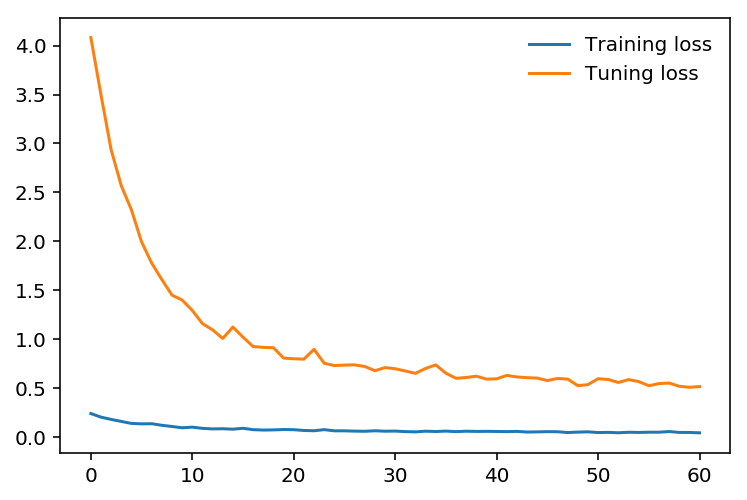

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss');
plt.plot(tune_losses, label='Tuning loss');
plt.legend(frameon=False)

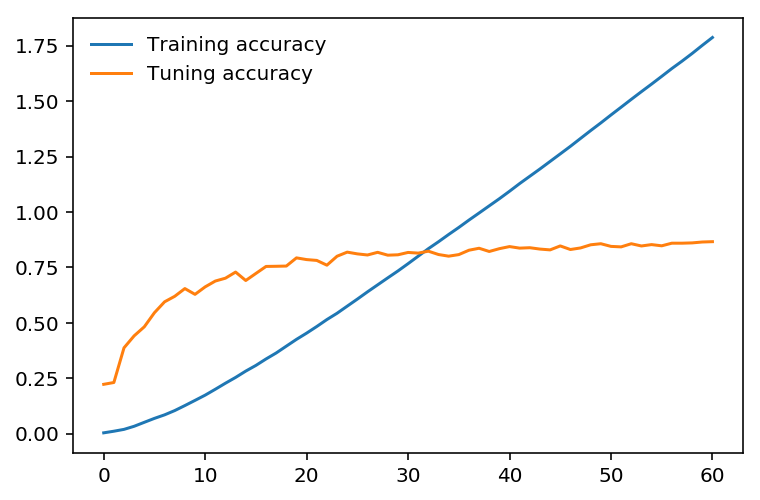

In [10]:
plt.plot(train_accuracy, label='Training accuracy');
plt.plot(tune_accuracy, label='Tuning accuracy');
plt.legend(frameon=False)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [11]:
# -- TEST THE MODEL

test_loss = 0
accuracy = 0
model.eval() # set model in evaluation mode

with torch.no_grad(): # reduces memory usage - we dont need to calculate the gradients in evaluation mode
                    
    for images, labels in testloader:

        # Move images and labels tensors to the default device (GPU if available)
        images = images.to(device)
        labels = labels.to(device)

        # Calculate the loss
        log_ps = model(images) # log of probability
        loss = criterion(log_ps, labels)
        test_loss += loss.item()

        # calculate the accuracy
        ps = torch.exp(log_ps) # get the actual probability
        top_p, top_class = ps.topk(1, dim=1) # top probabilities and classes

        equals = top_class == labels.view(*top_class.shape) # check how many images which have the correct classification. 
        # That *top_class.shape is passing all of the items in the top_class.shape into the view function call as separate arguments, without us even needing to know how many arguments are in the list. For example if the top_class has a shape say (32, 1), so *top_class.shape will pass 32, 1 to view function. Now this is as good as passing (top_class.shape[0],top_class.shape[1]). labels.view(top_class.shape[0],top_class.shape[1]) is equal to labels.view(*top_class.shape). The labels.view(*top_class.shape) is very useful because we dont have to know the exact shape for us to reshape them, we just use * and it will pack everything into a list and pass on to the view function for reshaping

        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        # after getting the top_class of the top_probability from torch.exp(output), we equal the top_class with the images labels (targets) to check if they match or not. The result from this equality is binary values [0,1]. Does this mean that 1 refers to class-label matching and 0 refers to class-label mismatching? Yes    

print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")

Test loss: 0.622.. Test accuracy: 0.830


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# Define the classifier definitions
model.class_to_idx = train_data.class_to_idx

# Save the checkpoint/model 
checkpoint = {'arch': 'vgg16',
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'class_to_idx': train_data.class_to_idx,
              'epochs': epochs,
              'learning_rate': optimizer.state_dict()['param_groups'][0]['lr'],
              'input_size': 25088,
              'output_size': 102,
              'hidden_layers': 512,
              'state_dict': model.state_dict()}

name = 'checkpoint.pth'
torch.save(checkpoint, name)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [13]:
name = 'checkpoint.pth'
#model = torch.load(name)
#model.keys()

In [14]:
# Loading the model and rebuilding the model

def load_model(filepath):
    
    # Run on GPU if possible
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # Assign the model data into a variable
    checkpoint = torch.load(filepath)
    print(checkpoint.keys())

    # Assign the name of the pretrained model as string
    new_model = models.vgg16(pretrained=True) # How to create from parameter?

    # Rebuild the model
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(checkpoint['input_size'], checkpoint['hidden_layers'])),
        ('relu1', nn.ReLU()),
        ('do1', nn.Dropout(0.2)),
        ('fc2', nn.Linear(checkpoint['hidden_layers'], checkpoint['output_size'])),
        ('output', nn.LogSoftmax(dim=1))
        ]))

    # Define new_model classifier
    new_model.classifier = classifier
    
    # Define new_model weights
    new_model.load_state_dict(checkpoint['state_dict'])

    # Send to the GPU?
    new_model.to(device)

    # Loading model to device
    new_model.to(device)
    
    return new_model 

new_model = load_model(name)
print(new_model)

dict_keys(['arch', 'state_dict', 'optimizer', 'class_to_idx', 'epochs', 'learning_rate', 'input_size', 'output_size', 'hidden_layers'])
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
# image_path = 'flowers/test/12/image_03994.jpg' # Tussilago doesnt work
# image_path = 'flowers/test/16/image_06657.jpg' # Doesnt work
# image_path = 'flowers/test/19/image_06170.jpg' # Doesnt work
# image_path = 'flowers/test/83/image_01774.jpg' # Doesnt work
image_path = 'flowers/test/83/image_01742.jpg' # Doesnt work hibisckus

In [16]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Open 1 image
    img = Image.open(image_path)
    #print(f'Image org size: {img.size}')
    #plt.imshow(img)
    #plt.show()
        
    # Scale
    width, height = img.size
    #print(f'Width: {width}') # [0]
    #print(f'Height: {height}') # [1]
    
    smallest_len = 256
    ratio = max(smallest_len/width, smallest_len/height)
    rW, rH = round(width*ratio), round(height*ratio)
    #SIZE=round(max(width*ratio, height*ratio)) # also works fine

    img.thumbnail((rW, rH), Image.ANTIALIAS)
    #print(f'Image thumbnail: {img.size}')
    
    # Crop
    crop_size = 224 
    width, height = img.size
    left = (width - crop_size)/2 # zero is in the top left corner
    top = (height - crop_size)/2
    right = left + crop_size
    bottom = top + crop_size
    
    img = img.crop((left, top, right, bottom))
    #print(f'Image size: {img.size}')
    
    #plt.imshow(img)
    #plt.show()
    
    # Change color channels (typically 0-255, but model expects floats 0-1)
    np_img = np.array(img)/255 # Normalize manually
    #print(f'np_img size: {np_img.size}')
    #print(f'np_img shape: {np_img.shape}')
    
    # Normalize the color channels
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np_img - mean)/std
    #print(f'np_img size: {np_img.size}')
    #print(f'np_img shape: {np_img.shape}')
    
    #plt.imshow(np.clip(np_img, 0, 1))
    
    # Transpose the color channels (pytorch expects 
    # color channels to be the first dimension, in PIL 
    # image and np array its the 3rd)
    processed_img = np_img.transpose(2,0,1)
    #print(f'processed_img size: {processed_img.size}')
    
    # Modify the output to a tensor
    tensor_img = torch.from_numpy(processed_img)
    #print(f'tensor_img shape: {tensor_img.shape}')
    
    return tensor_img

#image = process_image(image_path)
#print(f'Process Output shape: {image.shape}')

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    #print(f'Image size 1: {image.size}')
    
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    #image = image.numpy()[0].transpose((1, 2, 0))
    image = image.permute(1, 2, 0).numpy() 
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.imshow(image)

    return ax

#imshow(image);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
     # Set the model in evaluation mode
    model.eval()

    # Process Image - From jpeg to Tensor
    #print(img.size())
    img = process_image(image_path);
    #print(img.size())

    # Send tensor to device
    #print(img.is_cuda)
    img = img.to(device=device)
    #print(img.is_cuda)

    # No need to Flatten Tensor - but need to add an dimension
    #print(img.size())
    img = img.unsqueeze(0).float()
    #print(f'Image output size: {img.size()}')

    # Prediction - Run feed forward with current 
    # weights to make a prediction
    # Turn off auto_grad
    with torch.no_grad():
        output = model.forward(img)
        
    # Convert from log_probability to probability
    probs = torch.exp(output)

    # Pick the top 5 highest probabilities
    top_probs, top_idx = torch.topk(probs, topk)
    #print(top_probs, top_idx)

    return top_probs, top_idx

predict(image_path, new_model)

(tensor([[ 0.9524,  0.0459,  0.0005,  0.0004,  0.0002]], device='cuda:0'),
 tensor([[ 84,  49,  40,  72,  87]], device='cuda:0'))

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

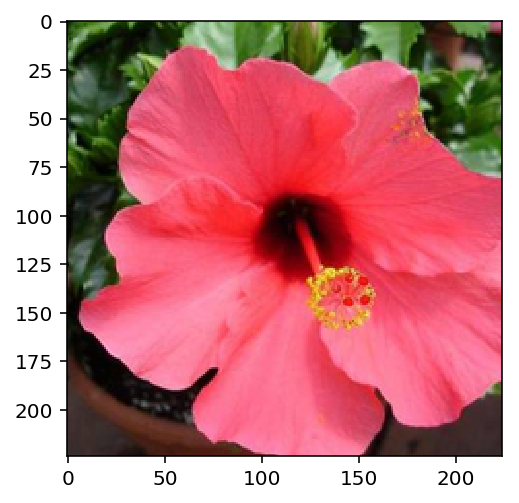

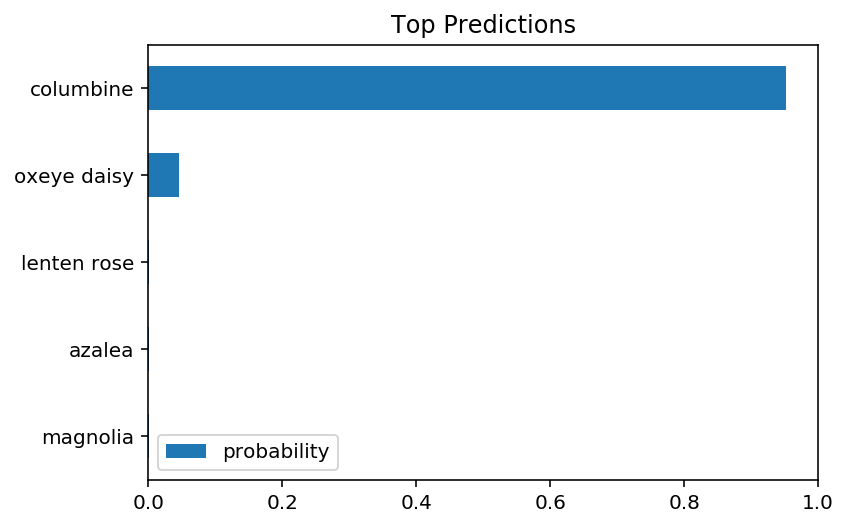

In [19]:
# Display an image along with the top 5 classes
def display_solution(image_path, model):
    
    import pandas as pd 
    #fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)

    # Display an image
    img = process_image(image_path)
    imshow(img); # Plots flower
    plt.show()

    # Display model predictions
    top_probs, top_classes = predict(image_path, new_model)

    # Create a dictionary/df of the top 5 highest probabilities and the corresponding flower name
    prob_dict = {}

    for idx, val in enumerate(top_classes[0]):
        #print(idx, val.item())
        #print(cat_to_name[str(val.item())])
        prob_dict[cat_to_name[str(val.item())]] = top_probs[0][idx].item()

    #print(prob_dict)
    df = pd.DataFrame.from_dict(prob_dict, orient='index', columns = ['probability'])

    # Barplot predictions
    df.plot(kind = 'barh');
    plt.title('Top Predictions');
    plt.gca().invert_yaxis()

    return 
    
display_solution(image_path, new_model);


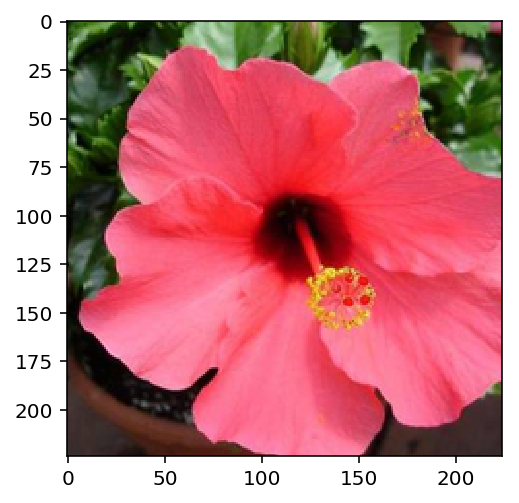

0 84
columbine
0.9523720145225525
0.9523720145225525
1 49
oxeye daisy
0.04594076797366142
0.04594076797366142
2 40
lenten rose
0.0004982433165423572
0.0004982433165423572
3 72
azalea
0.00039519279380328953
0.00039519279380328953
4 87
magnolia
0.000157455651788041
0.000157455651788041


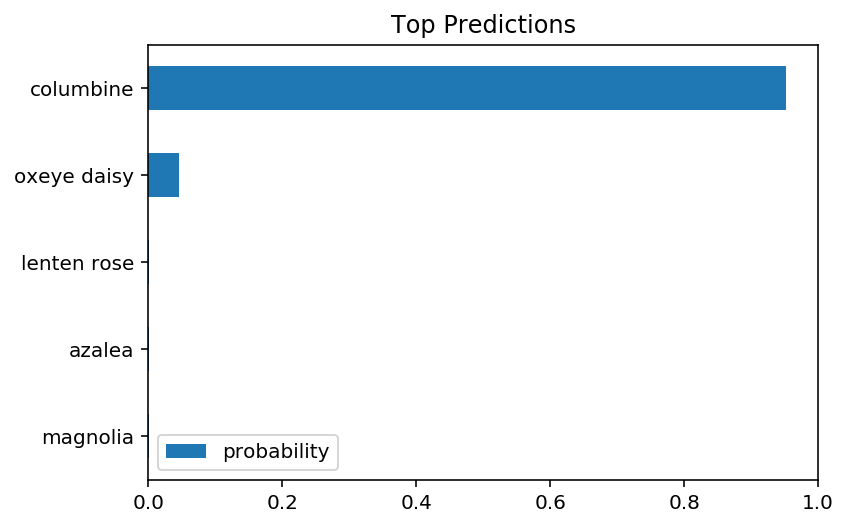

In [20]:
# Debug
import pandas as pd

# Display an image
img = process_image(image_path)
imshow(img); # Plots flower
plt.show()

# Display model predictions
top_probs, top_classes = predict(image_path, new_model)

# Create a dictionary/df of the top 5 highest probabilities and the corresponding flower name
prob_dict = {}

for idx, val in enumerate(top_classes[0]):
    print(idx, val.item())
    print(cat_to_name[str(val.item())])
    prob_dict[cat_to_name[str(val.item())]] = top_probs[0][idx].item()
    print(prob_dict[cat_to_name[str(val.item())]])
    print(top_probs[0][idx].item())
    
#print(prob_dict)
df = pd.DataFrame.from_dict(prob_dict, orient='index', columns = ['probability'])

# Barplot predictions
df.plot(kind = 'barh');
plt.title('Top Predictions');
plt.gca().invert_yaxis()

